# **Phase 2 - Milestone 2**

**Ediashta Revindra Amirussalam**
<br>FTDS-020-RMT

## Objective

## 00 - Import Libraries

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import glob
import random
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [8]:
tf.__version__

'2.10.1'

In [9]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 01 - Data Loading

### Google Colab

In [10]:
# from google.colab import drive
# drive.flush_and_unmount()

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# !rm ~/.kaggle

In [13]:
# !mkdir ~/.kaggle

# !cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle

In [14]:
# !ls ~/.kaggle

In [15]:
# !kaggle datasets download -d ananthu017/emotion-detection-fer

In [16]:
# !unzip -q /content/emotion-detection-fer.zip -d images

In [17]:
# main_path = ('/content/images')
# os.listdir(main_path)

### Local

In [18]:
main_path = ('./datasets')
os.listdir(main_path)

['test', 'train']

### Extraction

In [19]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
os.listdir(train_dir)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [20]:
def check_dir(dir=None, labels=None):
  i=0
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'Data', label, ' :', num_data)
    i+= num_data
  print('Total Data :', i)



In [21]:
print('train set: \n' + '='*50)
check_dir(train_dir,os.listdir(train_dir))
print('\ntest set: \n' + '='*50)
check_dir(test_dir,os.listdir(test_dir))

train set: 
Data angry  : 3995
Data disgusted  : 436
Data fearful  : 4097
Data happy  : 7215
Data neutral  : 4965
Data sad  : 4830
Data surprised  : 3171
Total Data : 28709

test set: 
Data angry  : 958
Data disgusted  : 111
Data fearful  : 1024
Data happy  : 1774
Data neutral  : 1233
Data sad  : 1247
Data surprised  : 831
Total Data : 7178


## 02 - EDA & Preprocessing

### Display Sample Image

(48, 48)


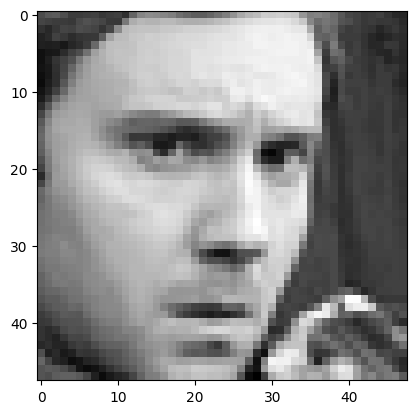

In [22]:
img = plt.imread(f'{train_dir}/angry/im0.png')
print(img.shape)
plt.imshow(img, cmap="gray")

#### Image Distribution

In [23]:
class_labels  = [class_name.capitalize() for class_name in os.listdir(train_dir)]
img_height = 48
img_width = 48
batch_size = 64

In [24]:
img_count = pd.DataFrame(columns=['label', 'count'])

for i in os.listdir(train_dir):
    value = len([fn for fn in os.listdir(f'{train_dir}/{i}/') if fn.endswith('.png')])
    img_count.loc[len(img_count.index)] = [i, value]

img_count.sort_values(by="count", ascending=False, inplace=True)

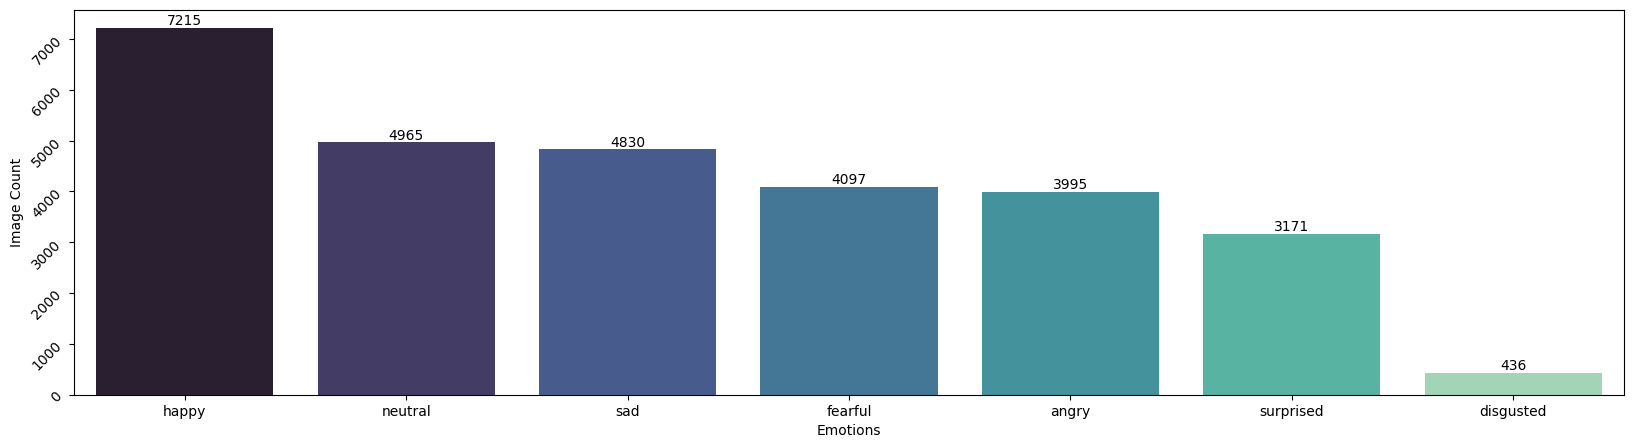

In [25]:
plt.figure(figsize=(20,5))
fig = sns.barplot(x="label",
                  y="count",
                  data=img_count,
                  palette="mako")
fig.set(xlabel="Emotions", ylabel="Image Count")

for i in fig.containers:
    fig.bar_label(i,)

plt.yticks(rotation=45)
plt.show()

### Individual Emotion Analysis

In [26]:
def visualize_img(title, train_dir):
    random.seed(5)
    images = random.sample([fn for fn in os.listdir(f'{train_dir}/{title}') if fn.endswith('.png')],7)
    fig, axes = plt.subplots(1,7, figsize=(21,5))

    for i, x in enumerate(images):
        img = plt.imread(f'{train_dir}/{title}/{x}')
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(title.capitalize())
        axes[i].axis('off')

    fig.tight_layout()

#### Angry

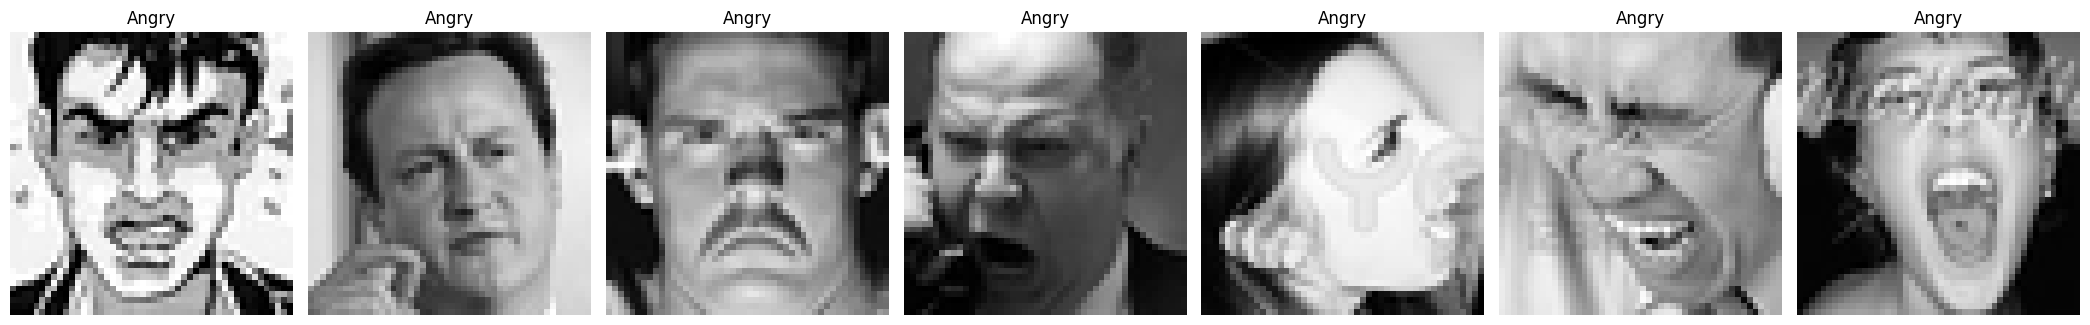

In [27]:
visualize_img('angry', train_dir)

#### Disgusted

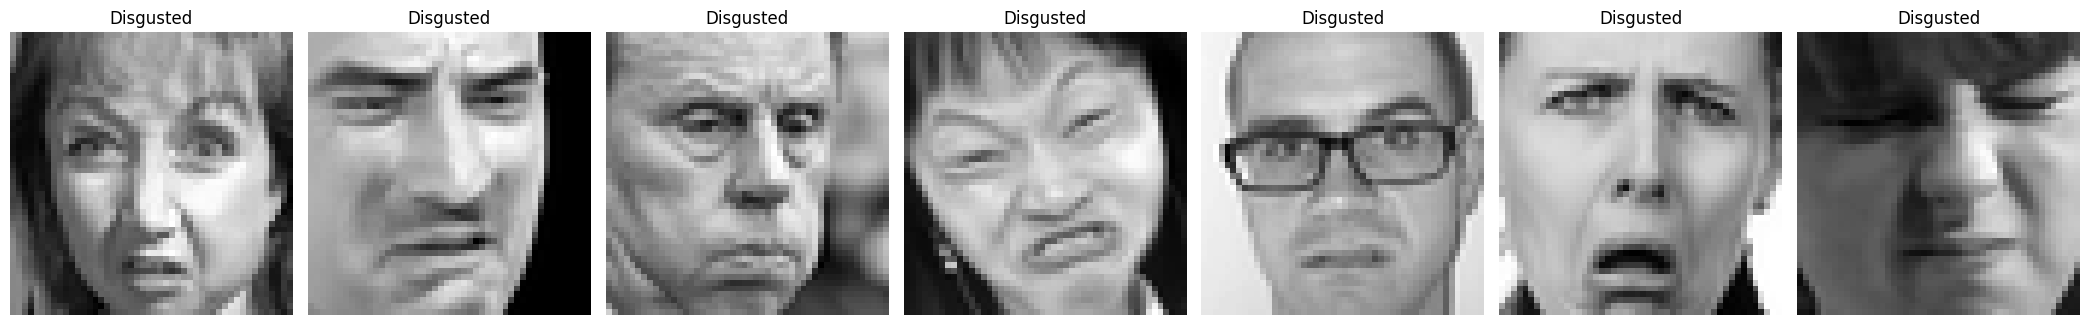

In [28]:
visualize_img('disgusted', train_dir)

#### Fearful

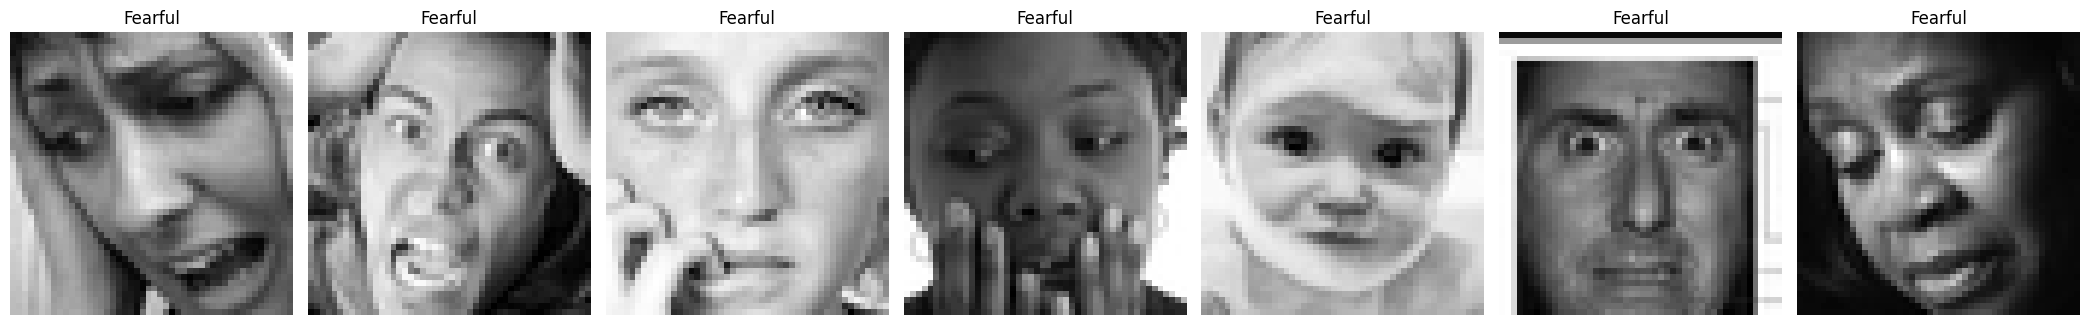

In [29]:
visualize_img('fearful', train_dir)

#### Happy

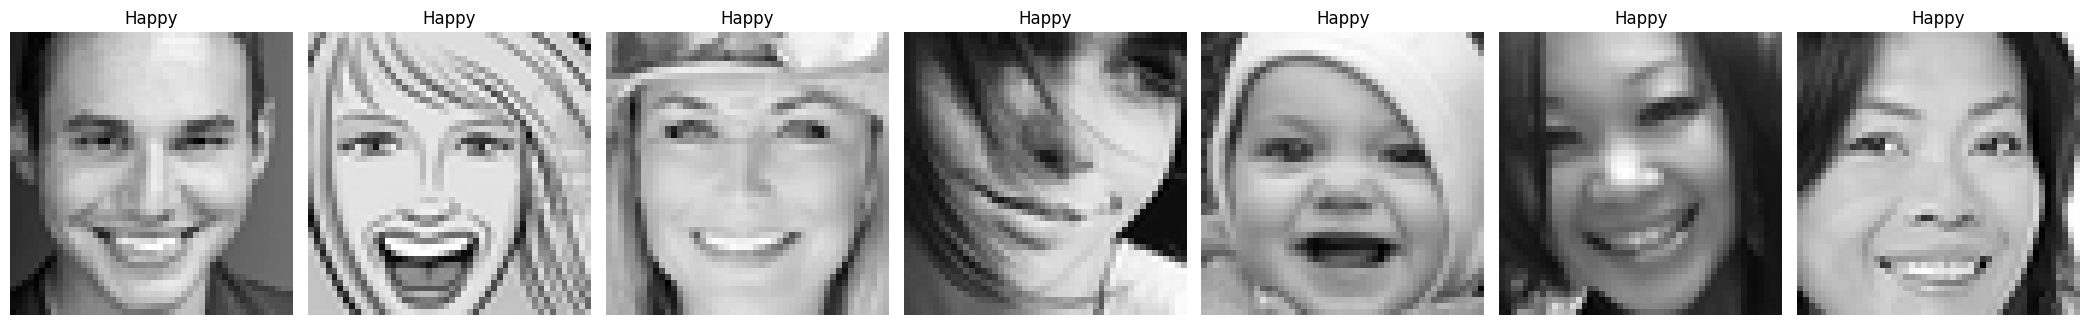

In [30]:
visualize_img('happy', train_dir)

#### Neutral

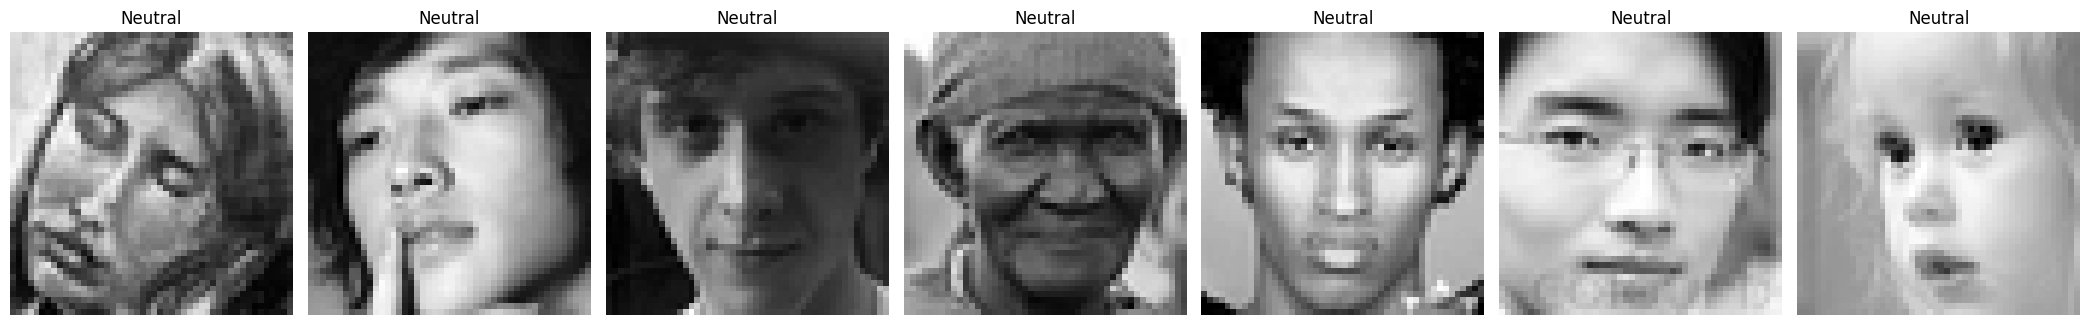

In [31]:
visualize_img('neutral', train_dir)

#### Sad

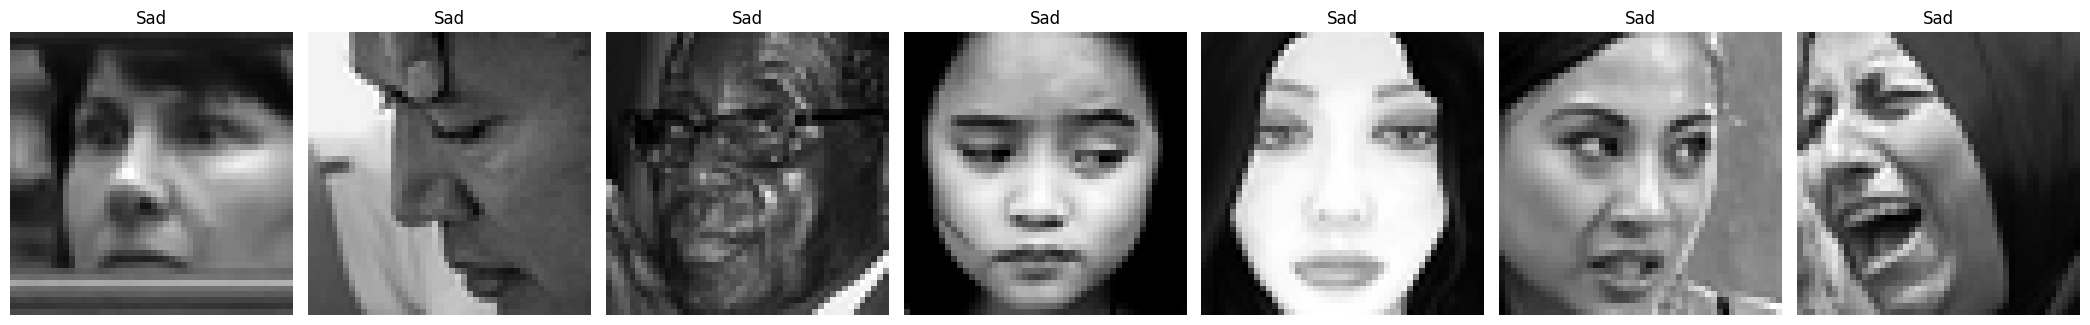

In [32]:
visualize_img('sad', train_dir)

#### Surprised

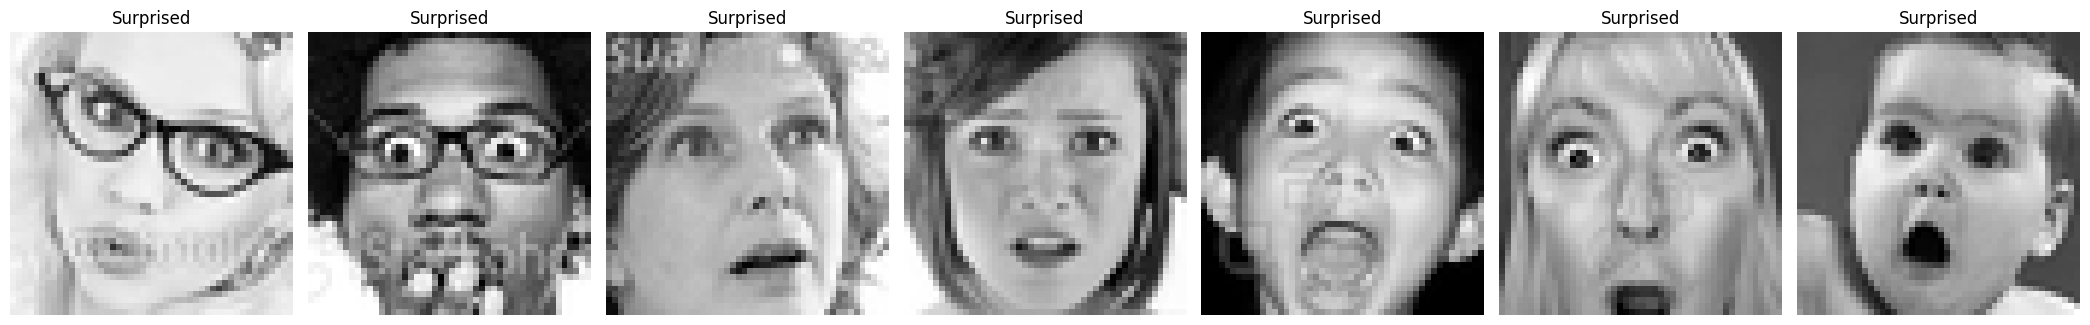

In [33]:
visualize_img('surprised', train_dir)

### Image Vector Mean

In [34]:
def img2np(path, list_of_filename, size = (48, 48)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size,
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [35]:
def find_mean_img(full_mat, title, axes, loc, size = (48, 48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)

    # mean_img = sharpened

    axes[loc].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axes[loc].set_title(f'Average {title}')
    return mean_img

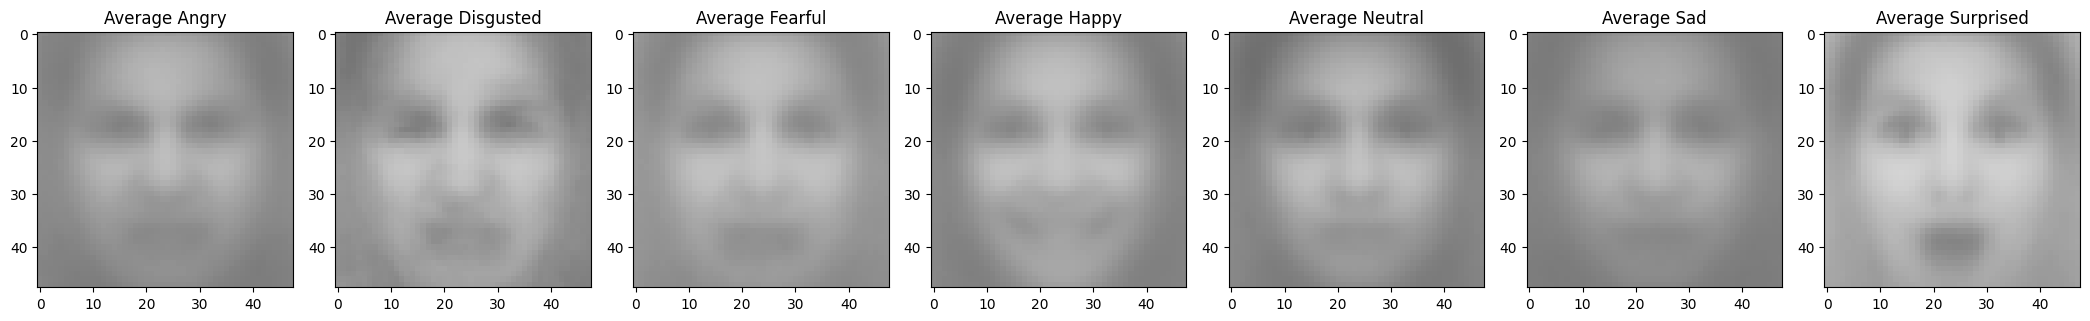

In [38]:
fig, axes= plt.subplots(1,7, figsize=(21,3))
count = 0

for i in os.listdir(train_dir):
    images = [fn for fn in os.listdir(f'{train_dir}/{i}') if fn.endswith('.png')]
    vector = img2np(f'{train_dir}/{i}/',images)
    find_mean_img(vector, i.capitalize(),axes, count)

    count+=1

plt.tight_layout()
plt.show()

### Preprocessing and Augmentation

In [173]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=15,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = True ,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

val_ds = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (img_height ,img_width),
                                                         batch_size = batch_size,
                                                         shuffle  = True ,
                                                         color_mode = "grayscale",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False ,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [174]:
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(64, 48, 48, 3)
(64, 7)


## 03 - Base Model

### Model Definition

In [191]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [192]:
# Define the input shape and number of classes for your dataset
input_shape = (img_height, img_width, 3)
num_classes = 7

In [193]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [194]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

### Model Training

In [195]:
history = model.fit(x = train_ds,
                    epochs = 50,
                    validation_data = val_ds)

Epoch 1/50


359/359 [==============================] - 27s 72ms/step - loss: 9.9527 - accuracy: 0.1671 - val_loss: 8.8761 - val_accuracy: 0.2513
Epoch 2/50
359/359 [==============================] - 26s 72ms/step - loss: 9.1632 - accuracy: 0.1872 - val_loss: 8.4445 - val_accuracy: 0.1928
Epoch 3/50
359/359 [==============================] - 24s 68ms/step - loss: 8.4840 - accuracy: 0.1963 - val_loss: 7.8061 - val_accuracy: 0.2073
Epoch 4/50
359/359 [==============================] - 25s 68ms/step - loss: 7.7831 - accuracy: 0.2020 - val_loss: 7.2458 - val_accuracy: 0.2338
Epoch 5/50
359/359 [==============================] - 24s 68ms/step - loss: 7.1110 - accuracy: 0.2109 - val_loss: 6.5715 - val_accuracy: 0.2376
Epoch 6/50
359/359 [==============================] - 25s 68ms/step - loss: 6.4511 - accuracy: 0.2134 - val_loss: 6.0968 - val_accuracy: 0.2061
Epoch 7/50
359/359 [==============================] - 24s 68ms/step - loss: 5.7956 - accuracy: 0.2218 - val_loss: 5.4031 - val_accuracy: 0.2439
Epo

In [196]:
history_df = pd.DataFrame(history.history)

history_df.tail()

,loss,accuracy,val_loss,val_accuracy
45,1.596892,0.546717,1.783700,0.476049
46,1.601986,0.546369,1.739997,0.497126
47,1.588541,0.550679,1.693422,0.495210
48,1.586819,0.550200,1.989922,0.448528
49,1.583763,0.554728,1.740093,0.505138


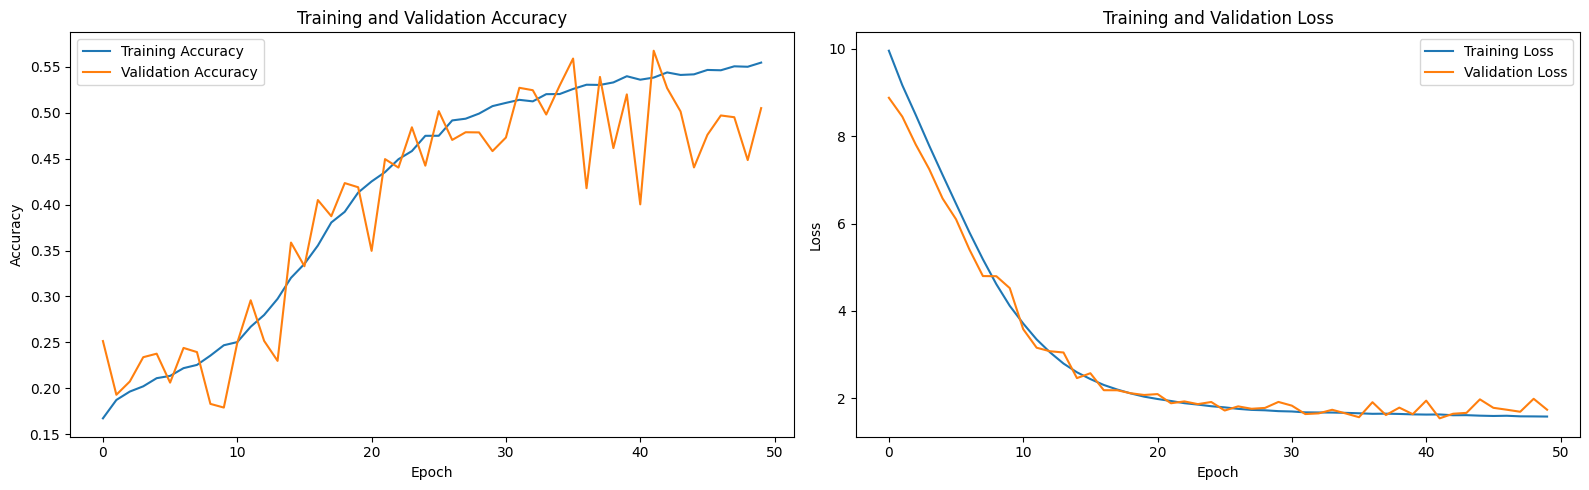

In [197]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

In [198]:
model.trainable = False
# model.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_default.h5") #google colab
model.save('./model/model_default.h5') #local

### Model Evaluation

In [199]:
model.evaluate(test_ds)
preds = model.predict(test_ds)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_ds.labels)

113/113 [==============================] - 3s 23ms/step


In [200]:
cm_array = confusion_matrix(y_true=y_test, y_pred=y_preds)

In [201]:
cm_array

array([[ 374,    0,    1,  113,  143,  280,   47],
       [  44,    0,    0,   16,    8,   39,    4],
       [ 131,    0,   53,  155,  145,  371,  169],
       [  52,    0,    6, 1331,  143,  189,   53],
       [  89,    0,    5,  118,  557,  331,  133],
       [ 113,    0,    9,  137,  246,  687,   55],
       [  40,    0,   13,   98,   50,   64,  566]], dtype=int64)

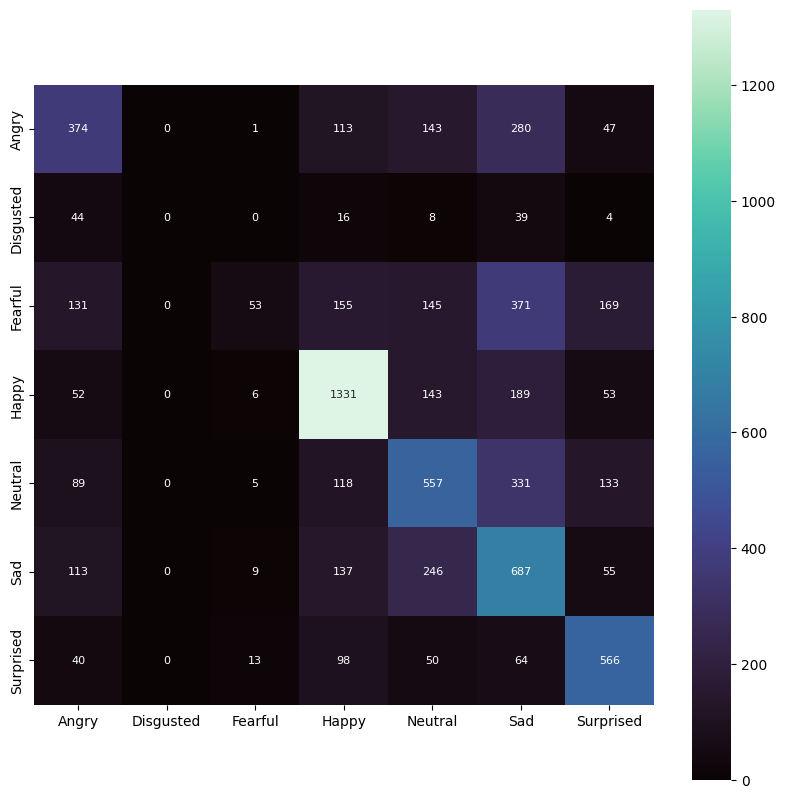

In [202]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)


In [203]:
print(classification_report(y_true=y_test, y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.44      0.39      0.42       958
           1       0.00      0.00      0.00       111
           2       0.61      0.05      0.10      1024
           3       0.68      0.75      0.71      1774
           4       0.43      0.45      0.44      1233
           5       0.35      0.55      0.43      1247
           6       0.55      0.68      0.61       831

    accuracy                           0.50      7178
   macro avg       0.44      0.41      0.39      7178
weighted avg       0.51      0.50      0.47      7178



c:\Users\defal\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\defal\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\defal\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 04 - Fine Tuned Model

### Model Definition

In [204]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [205]:
def final_model(inputs):
    feature_extractor = tf.keras.applications.VGG16(input_shape=input_shape,
                                               include_top=False,
                                               weights="imagenet")(inputs)

    x = Flatten()(feature_extractor)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu", 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation="relu", 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu", 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5) (x)
    x = Dense(num_classes, 
              activation="softmax", 
              name="classification")(x)
    return x

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=input_shape)
    classification_output = final_model(inputs)

    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

    return model

In [206]:
def build_model(optim):
    
    model = Sequential(name='DCNN')

    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    model.add(BatchNormalization(name='batchnorm_2'))
    
    model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_1'))
    model.add(Dropout(0.4, name='dropout_1'))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    model.add(BatchNormalization(name='batchnorm_4'))
    
    model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_2'))
    model.add(Dropout(0.4, name='dropout_2'))

    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    model.add(BatchNormalization(name='batchnorm_5'))
    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    model.add(BatchNormalization(name='batchnorm_6'))
    
    model.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_3'))
    model.add(Dropout(0.5, name='dropout_3'))

    model.add(Flatten(name='flatten'))
        
    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_7'))
    
    model.add(Dropout(0.6, name='dropout_4'))
    
    model.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    return model

In [208]:
optims = [
    tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    tf.keras.optimizers.Adam(0.001),
]

model_ft = build_model(optims[1]) 

model_ft.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

### Model Training

In [209]:
modelCheckpointCallback = ModelCheckpoint(
    # filepath='/content/drive/MyDrive/FTDS/Emotion Classification', #google colab
    filepath= './deployment/model/',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
)

earlyStoppingCallback = EarlyStopping(monitor='accuracy',
                                      patience=5,
                                      verbose= 1 ,
                                      restore_best_weights=True
                                      )

reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0)

In [210]:
history_ft = model_ft.fit(x = train_ds,
                    epochs = 100 ,
                    validation_data = val_ds , 
                    callbacks= [earlyStoppingCallback,
                                modelCheckpointCallback,
                                reduce_lr])

Epoch 1/75
359/359 [==============================] - 28s 71ms/step - loss: 2.2446 - accuracy: 0.2247 - val_loss: 2.0652 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 2/75
359/359 [==============================] - 54s 149ms/step - loss: 1.7458 - accuracy: 0.3204 - val_loss: 1.6032 - val_accuracy: 0.3735 - lr: 0.0010
Epoch 3/75
359/359 [==============================] - 56s 155ms/step - loss: 1.5827 - accuracy: 0.3845 - val_loss: 1.4363 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 4/75
359/359 [==============================] - 46s 127ms/step - loss: 1.4749 - accuracy: 0.4331 - val_loss: 1.4461 - val_accuracy: 0.4449 - lr: 0.0010
Epoch 5/75
359/359 [==============================] - 25s 70ms/step - loss: 1.3870 - accuracy: 0.4641 - val_loss: 1.2661 - val_accuracy: 0.5081 - lr: 0.0010
Epoch 6/75
359/359 [==============================] - 22s 61ms/step - loss: 1.3383 - accuracy: 0.4908 - val_loss: 1.2476 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 7/75
359/359 [==============================] - 2

In [211]:
history_ft_df = pd.DataFrame(history_ft.history)

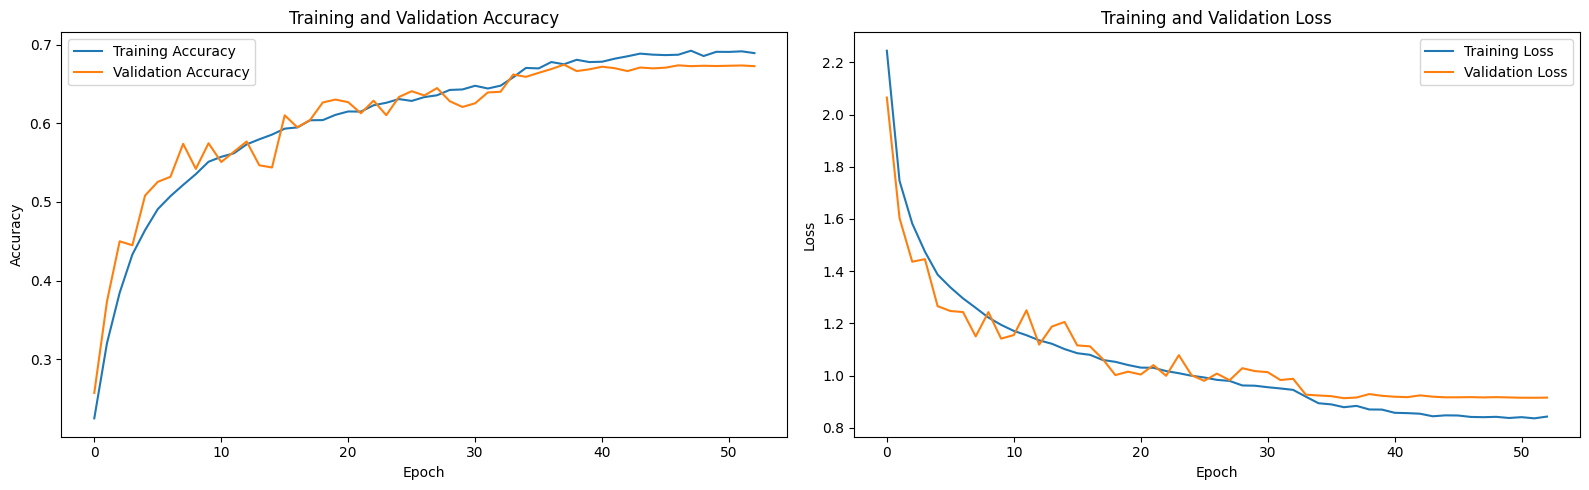

In [212]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ft_df["accuracy"], label="Training Accuracy")
plt.plot(history_ft_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_ft_df["loss"], label="Training Loss")
plt.plot(history_ft_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

In [234]:
model_ft.trainable = False
# model_ft.save("/content/drive/MyDrive/FTDS/Emotion Classification/model_fine_tune.h5") #google colab
model_ft.save('./model/model_fine_tune.h5') #local

### Model Evaluation

In [235]:
model_ft.evaluate(test_ds)
preds_ft = model_ft.predict(test_ds)
y_preds_ft = np.argmax(preds_ft , axis = 1 )
y_test_ft = np.array(test_ds.labels)

113/113 [==============================] - 3s 25ms/step


In [236]:
cm_array_ft = confusion_matrix(y_true=y_test_ft, y_pred=y_preds_ft)

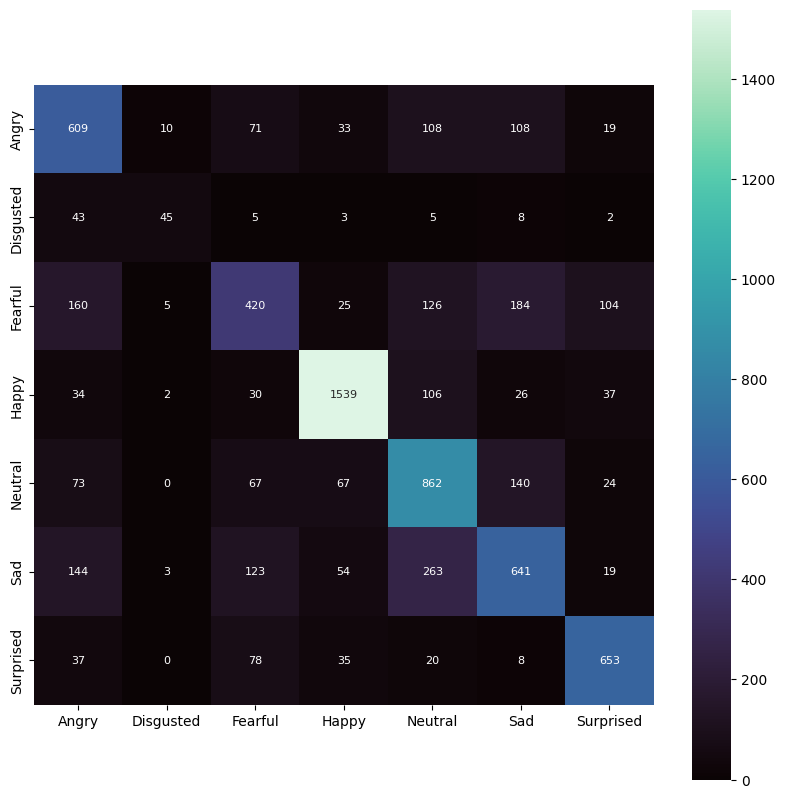

In [237]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_array_ft, cmap="mako",
                 annot=True, square=True,
                 annot_kws={"size": 8}, fmt='g',
                 xticklabels=class_labels, yticklabels=class_labels)


In [238]:
print(classification_report(y_true=y_test_ft, y_pred=y_preds_ft))

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       958
           1       0.69      0.41      0.51       111
           2       0.53      0.41      0.46      1024
           3       0.88      0.87      0.87      1774
           4       0.58      0.70      0.63      1233
           5       0.57      0.51      0.54      1247
           6       0.76      0.79      0.77       831

    accuracy                           0.66      7178
   macro avg       0.65      0.62      0.63      7178
weighted avg       0.66      0.66      0.66      7178



## 05 - Prediction Analysis

In [257]:
# Get the file paths and corresponding labels from test_ds
file_paths = test_ds.filepaths
labels = test_ds.classes

# Create a DataFrame
data = {'file_path': file_paths, 'label': labels}
data_true = pd.DataFrame(data)

emotion_true=[]
for i,x in data_true.iterrows():
    if x['label'] == 0:
        value = 'Angry'
    elif x['label'] == 1:
        value = 'Disgusted'
    elif x['label'] == 2:
        value = 'Fearful'
    elif x['label'] == 3:
        value = 'Happy'
    elif x['label'] == 4:
        value = 'Neutral'
    elif x['label'] == 5:
        value = 'Sad'
    elif x['label'] == 6:
        value = 'Surprised'
    else:
        value = 'Unknown'
    emotion_true.append(value)

data_true['label']=emotion_true

In [258]:
prediction = pd.DataFrame(y_preds_ft, columns=['prediction'])

In [259]:
emotion = []
for i,x in prediction.iterrows():
    if x[0] == 0:
        value = 'Angry'
    elif x[0] == 1:
        value = 'Disgusted'
    elif x[0] == 2:
        value = 'Fearful'
    elif x[0] == 3:
        value = 'Happy'
    elif x[0] == 4:
        value = 'Neutral'
    elif x[0] == 5:
        value = 'Sad'
    elif x[0] == 6:
        value = 'Surprised'
    else:
        value = 'Unknown'
    emotion.append(value)

In [260]:
prediction['emotion'] = emotion
prediction['path'] = data_true['file_path']
prediction['true emotion'] = data_true['label']

In [273]:
def compare_pred(label, prediction):
    fig, axs = plt.subplots(2, 7, figsize=(21, 5))
    
    count = 0
    for i, x in prediction.iterrows():
        if count < 7:
            image = plt.imread(x['path'])
            if x['true emotion'] == label and x['emotion'] == label:
                axs[0, count].set_title(f"Pred: {x['emotion']}, True: {x['true emotion']}")
                axs[0, count].imshow(image, cmap="gray")
                count += 1
        elif count < 14:
            image = plt.imread(x['path'])
            if x['true emotion'] == label and x['emotion'] != label:
                axs[1, count-7].set_title(f"Pred: {x['emotion']}, True: {x['true emotion']}")
                axs[1, count-7].imshow(image, cmap="gray")
                count += 1
    
    fig.axes[0].set_ylabel("Positive Prediction")
    fig.axes[7].set_ylabel("Negative Prediction")
    fig.tight_layout()

### Angry Prediction

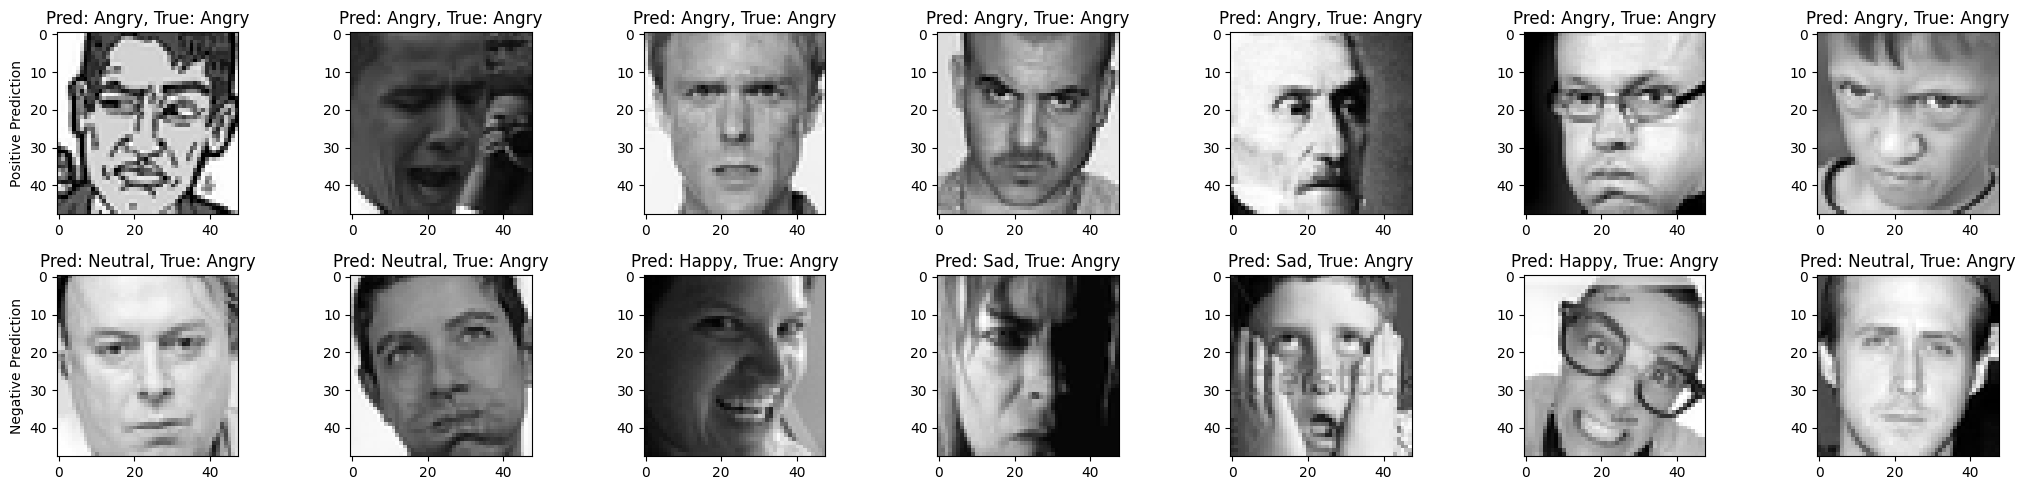

In [274]:
compare_pred('Angry', prediction)

### Disgusted Prediction

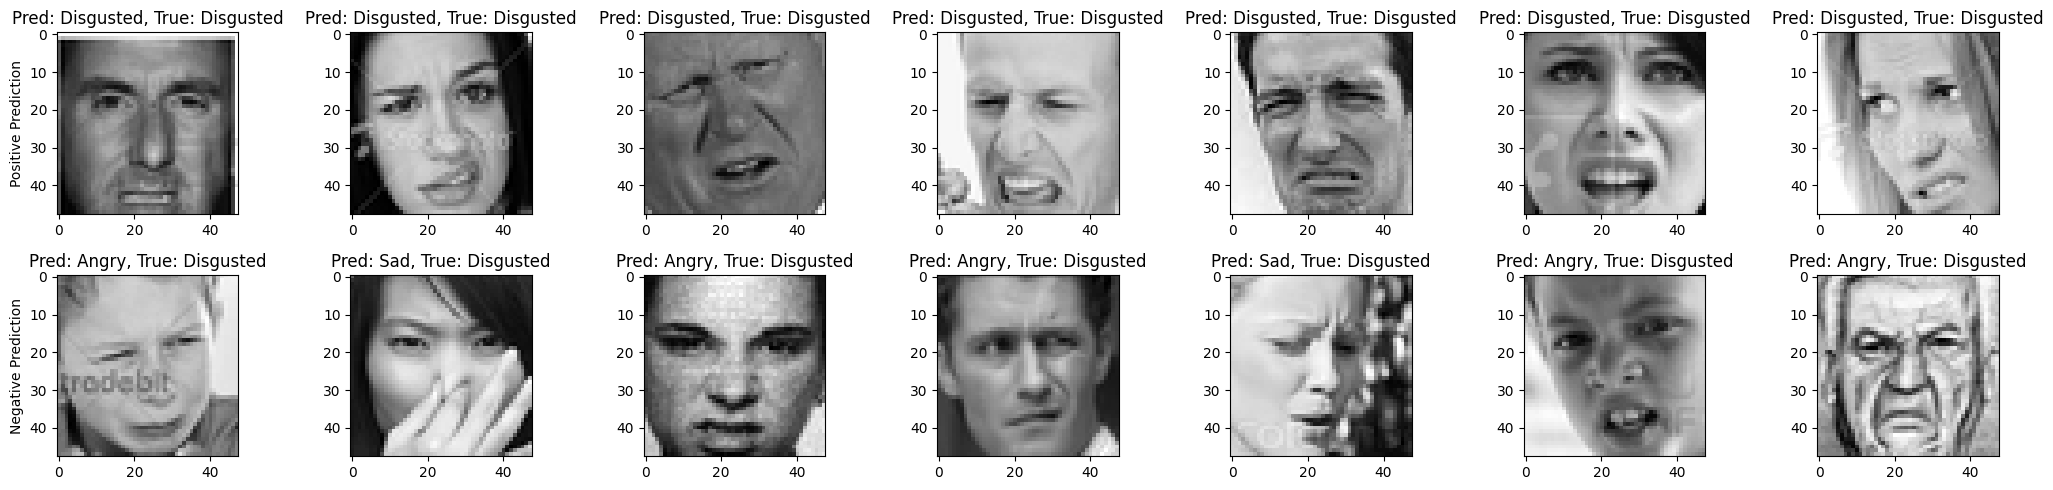

In [276]:
compare_pred('Disgusted', prediction)

### Fearful Prediction

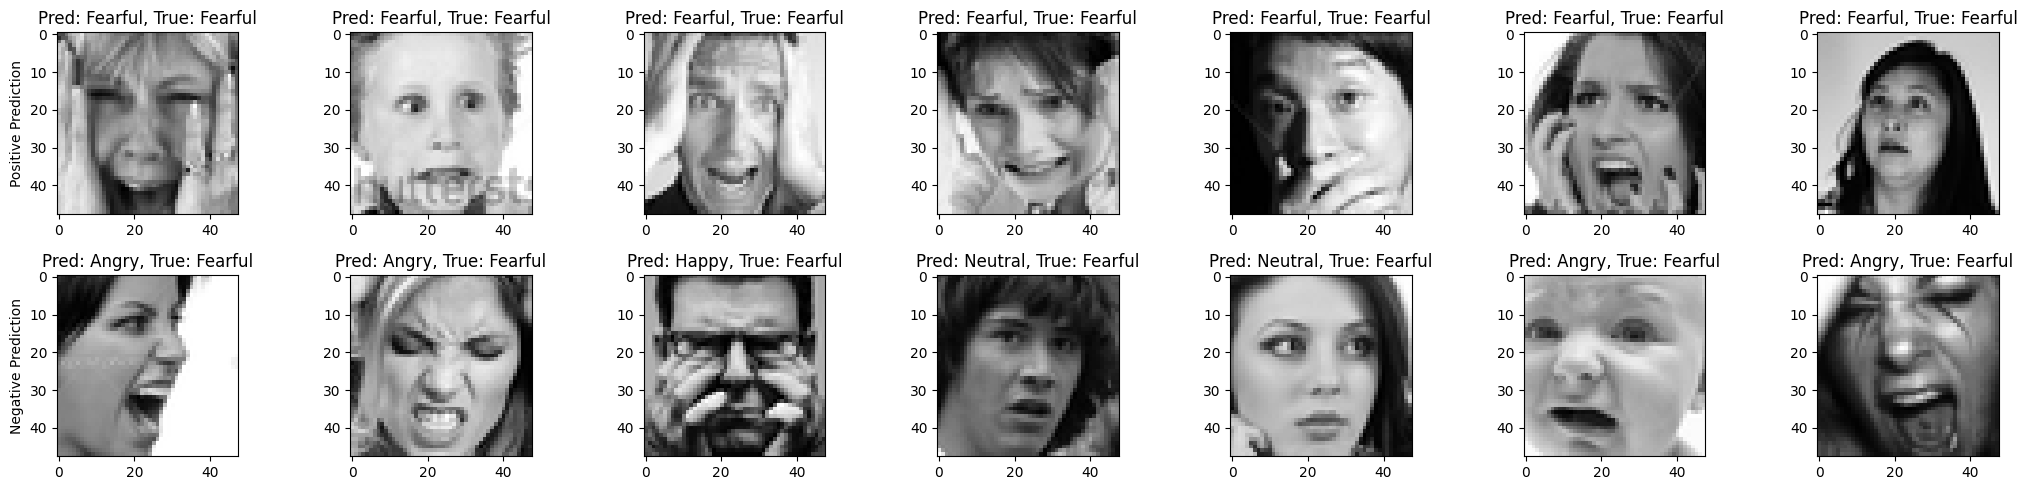

In [277]:
compare_pred('Fearful', prediction)

### Happy Prediction

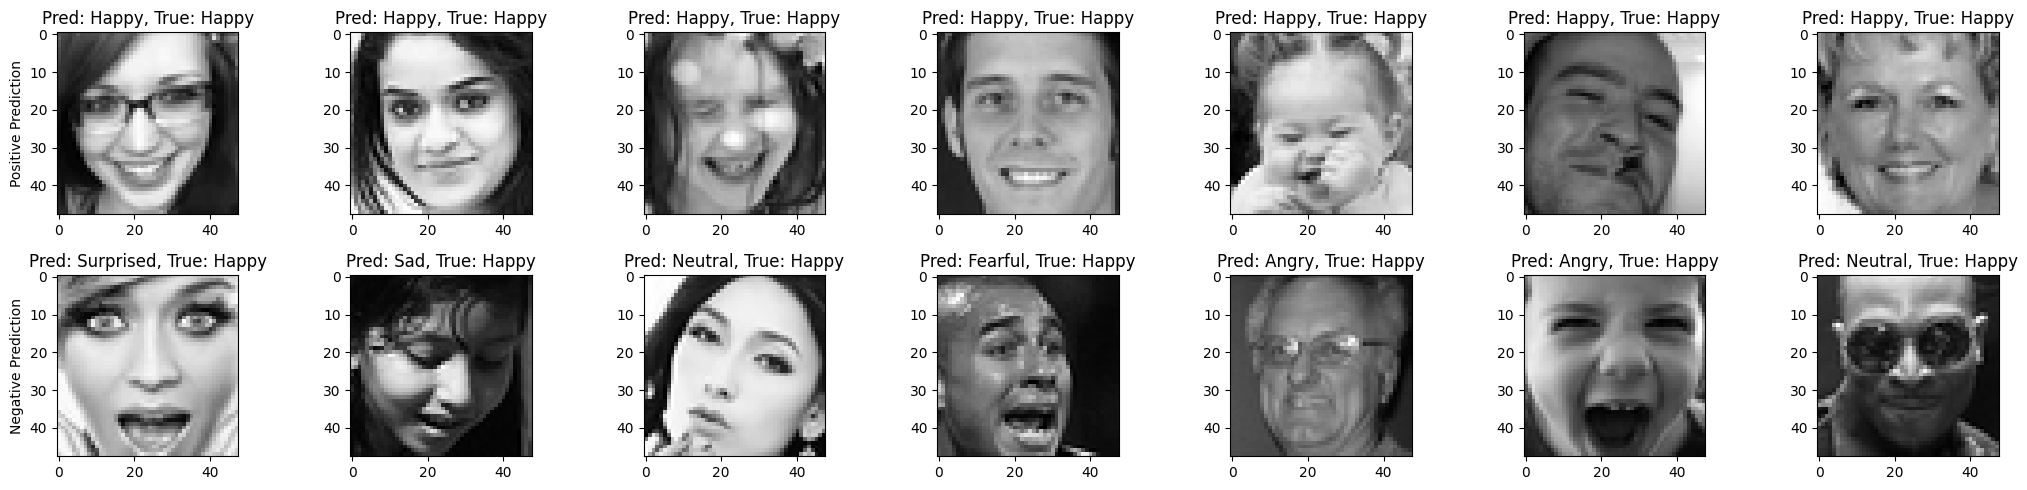

In [278]:
compare_pred('Happy', prediction)

### Neutral Prediction

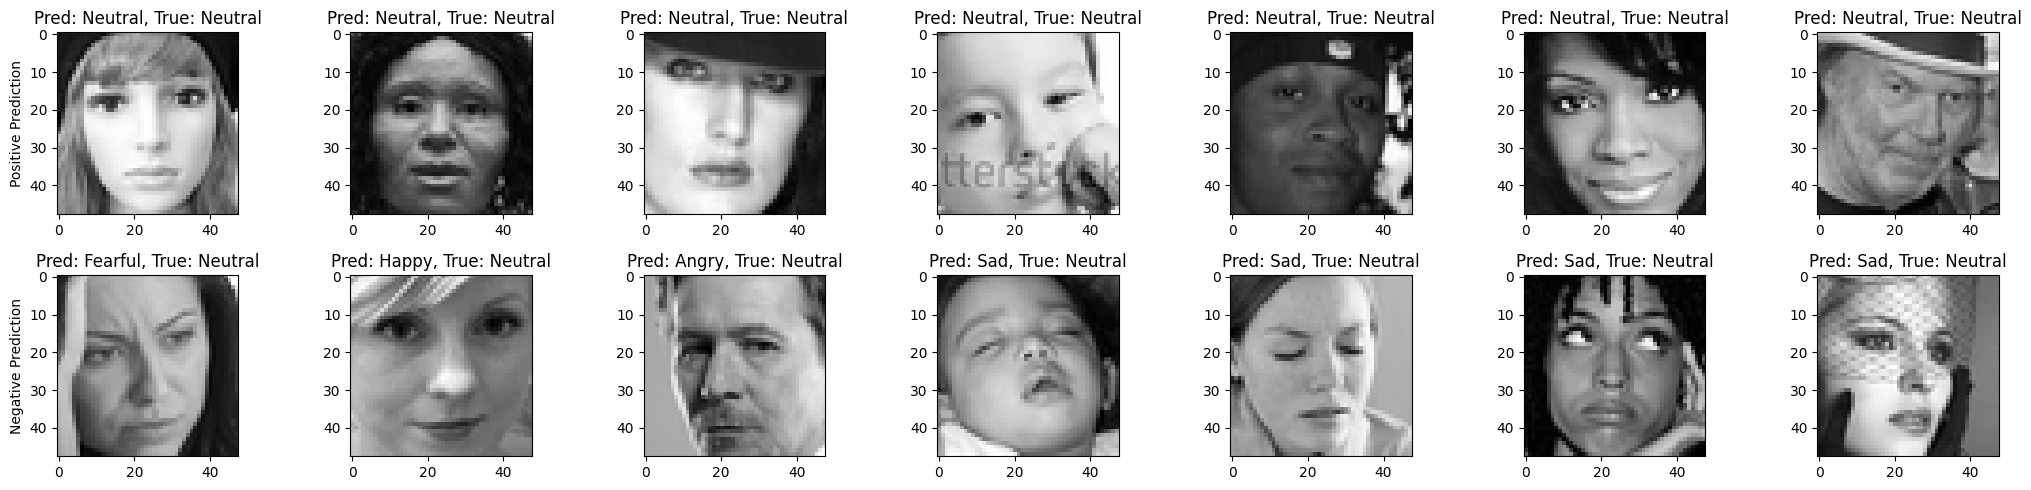

In [279]:
compare_pred('Neutral', prediction)

### Sad Prediction

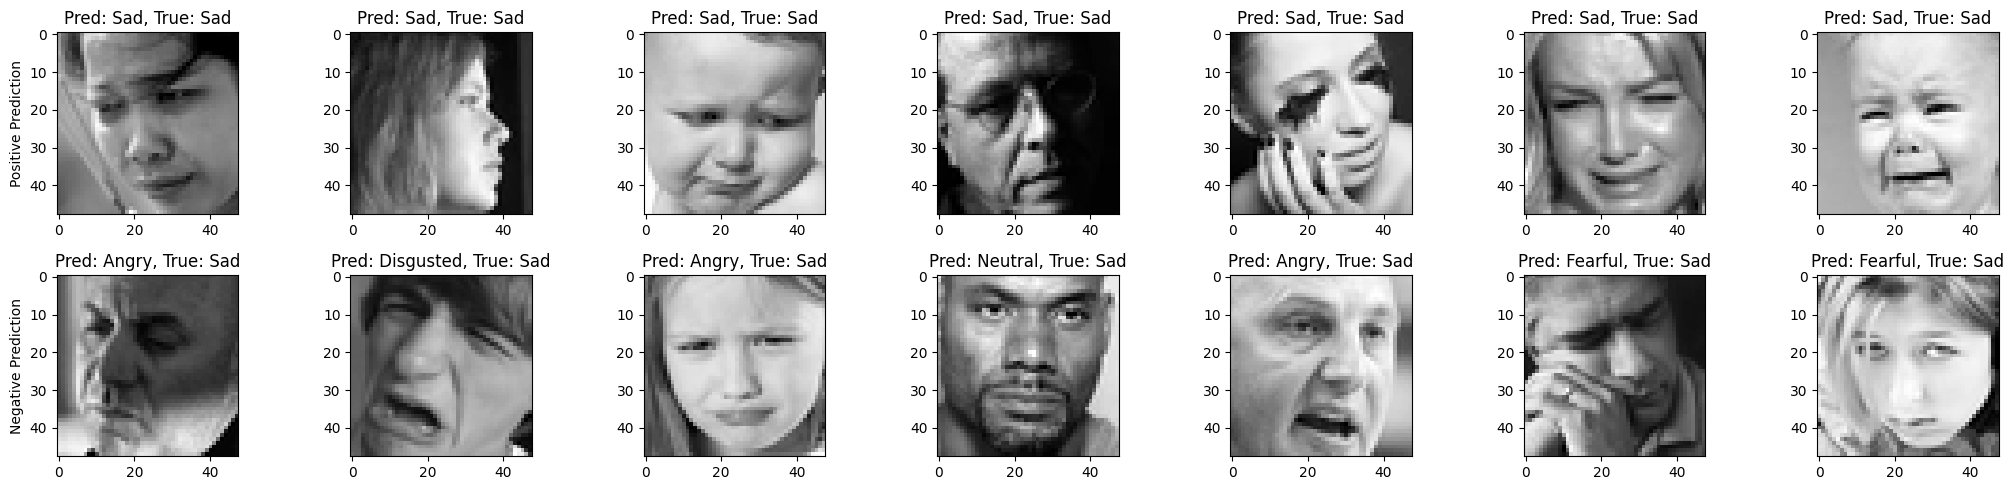

In [280]:
compare_pred('Sad', prediction)

### Suprised Prediction

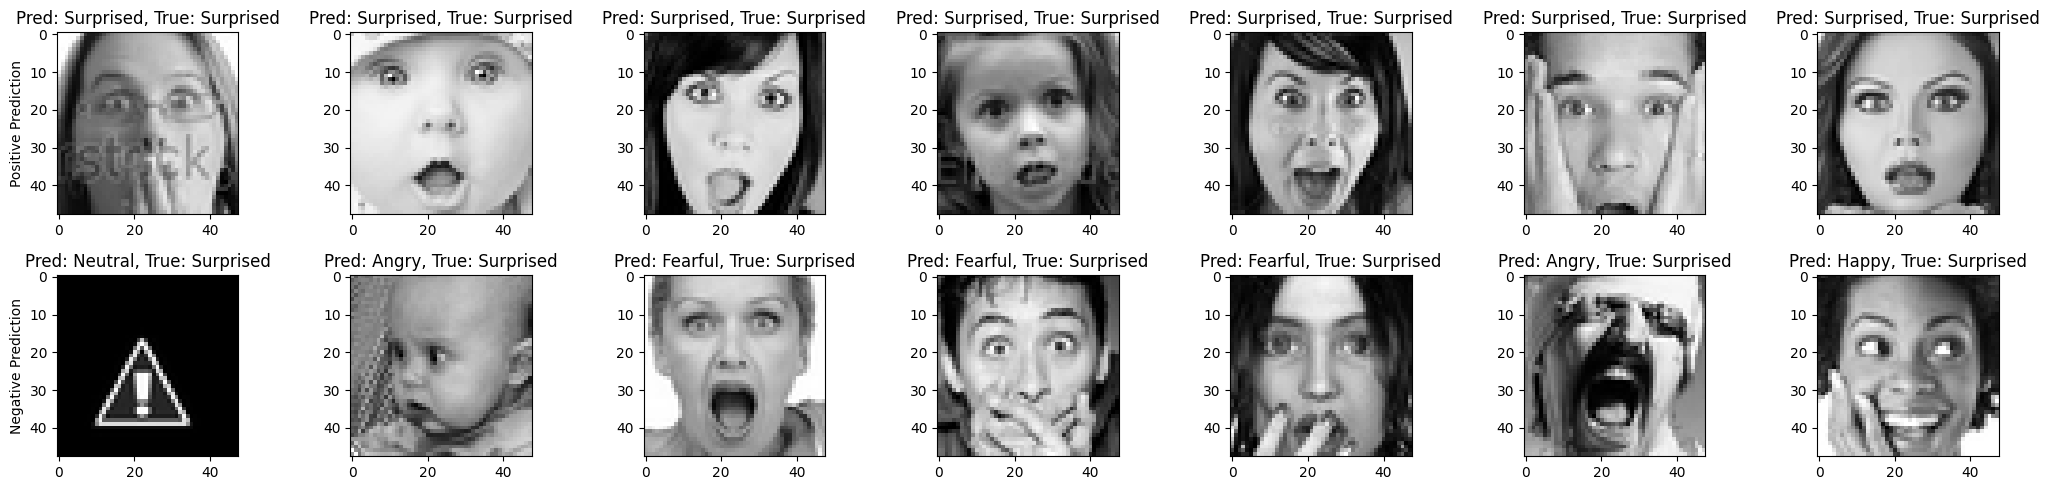

In [281]:
compare_pred('Surprised', prediction)

## 07 - Inferencing

In [373]:
emotion_classification_model = load_model('./model/model_fine_tune.h5')

In [374]:
inf_path = './inferencing/image/'
image_inf = os.listdir(inf_path)

In [378]:
model_ft.evaluate(test_ds)
preds_ft = model_ft.predict_proba(test_ds)
y_preds_ft = np.argmax(preds_ft , axis = 1 )
y_test_ft = np.array(test_ds.labels)

113/113 [==============================] - 3s 23ms/step - loss: 0.9346 - accuracy: 0.6644


AttributeError: 'Sequential' object has no attribute 'predict_proba'

1/1 [==============================] - 0s 22ms/step


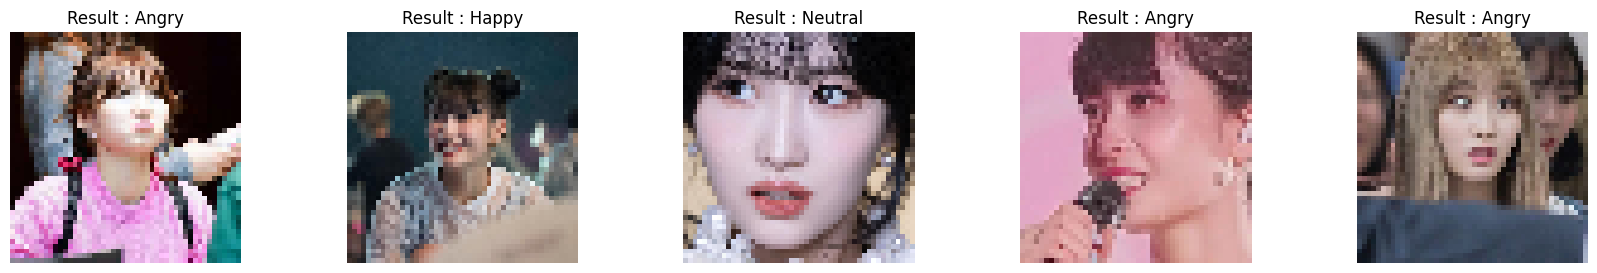

In [376]:
fig, axs = plt.subplots(1,5, figsize=(21,3))
prediction_result = pd.DataFrame(columns=["image", "prediction", "proba"])

for x, i in enumerate(image_inf):
    img = image.load_img(f'{inf_path}{i}', target_size=(48,48), keep_aspect_ratio=True)
    axs[x].imshow(img)
    axs[x].axis('off')

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    prediction_inf = emotion_classification_model.predict(img_batch)
    result_max_proba = np.argmax(prediction_inf, axis=1)
    pred_class = pd.DataFrame(class_labels).loc[result_max_proba][0].values[0]
    axs[x].set_title(f'Result : {pred_class}')
    
    prediction_result.loc[len(prediction_result.index)] = [i, pred_class, prediction_inf[0]] 

In [377]:
prediction_result

,image,prediction,proba
0,momo_disgusted.jpg,Angry,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,momo_happy.jpg,Happy,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,momo_neutral.jpg,Neutral,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
3,momo_sad.jpg,Angry,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,momo_surprised.jpg,Angry,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
